In [1]:
import os
import sys
sys.path.append('/data1/yang_liu/python_workspace/GSPL')

import json
import torch
import torch_scatter
import pickle
import numpy as np
import matplotlib.pyplot as plt
from internal.utils.gaussian_model_loader import GaussianModelLoader

In [2]:
def voxel_filtering_no_gt(voxel_size, xy_range, target_xyz, require_unq_inv=False):
    assert len(xy_range) == 4, "Unrecognized xy_range format"
    with torch.no_grad():

        voxel_index = torch.div(torch.tensor(target_xyz[:, :2]).float() - xy_range[None, :2], voxel_size[None, :], rounding_mode='floor')
        voxel_coords = voxel_index * voxel_size[None, :] + xy_range[None, :2] + voxel_size[None, :] / 2

        new_coors, unq_inv, unq_cnt = torch.unique(voxel_coords, return_inverse=True, return_counts=True, dim=0)
        feat_mean = torch_scatter.scatter(target_xyz[:, 2], unq_inv, dim=0, reduce='mean')
        feat_std = torch_scatter.scatter_std(target_xyz[:, 2], unq_inv, dim=0)

        mask = target_xyz[:, 2] > feat_mean[unq_inv] + 2 * feat_std[unq_inv]

    return mask

In [3]:
# load model and dataset
config_path = "../outputs/citygs_lfls_coarse/config.yaml"
model, renderer = GaussianModelLoader.search_and_load(
    "../outputs/citygs_lfls_coarse",
    sh_degree=3,
    device="cuda",
)
print("Gaussian count: {}".format(model.get_xyz.shape[0]))
xyz = model.get_xyz.cpu().numpy()

Gaussian count: 10681790


In [4]:
traj_path = "../data/GauU_Scene/LFLS/traj_ellipse"
traj_files = os.listdir(traj_path)
traj_files.sort()

w2c, cam_centers = [], []
for traj_file in traj_files:
    with open(os.path.join(traj_path, traj_file), "rb") as f:
        traj = pickle.load(f)
        w2c.append(traj["world_view_transform"])
        cam_center = np.linalg.inv(traj["world_view_transform"])[3, :3]
        cam_centers.append(cam_center)
w2c = np.stack(w2c)
cam_centers = np.stack(cam_centers)
coord_std = np.std(cam_centers, axis=0)
# use dimension with minimum std as the up direction
up_dim = np.argmin(coord_std)
x_dim = (up_dim + 1) % 3
y_dim = (up_dim + 2) % 3
delta_rate = 0.1
x_min = np.min(cam_centers[:, x_dim])
x_max = np.max(cam_centers[:, x_dim])
x_delta = (x_max - x_min) * delta_rate
y_min = np.min(cam_centers[:, y_dim])
y_max = np.max(cam_centers[:, y_dim])
y_delta = (y_max - y_min) * delta_rate

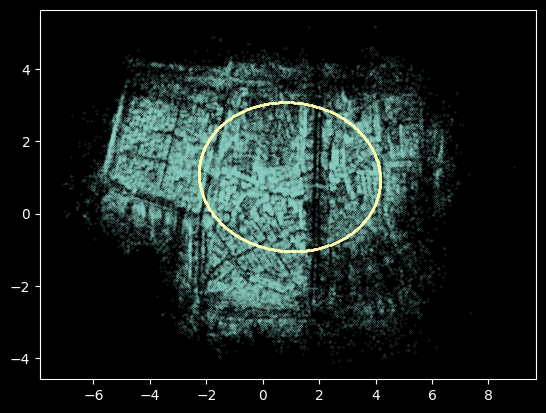

In [5]:
plt.figure()
plt.scatter(xyz[::100, x_dim], xyz[::100, y_dim], s=0.01)
plt.scatter(cam_centers[:, x_dim]+1, cam_centers[:, y_dim]+1, s=1)
# plt.xlim(x_min - x_delta, x_max + x_delta)
# plt.ylim(y_min - y_delta, y_max + y_delta)
plt.show()

In [6]:
import yaml
from internal.utils.general_utils import parse
from internal.dataparsers.colmap_block_dataparser import ColmapBlockDataParser
from internal.dataparsers.estimated_depth_colmap_block_dataparser import EstimatedDepthColmapDataParser

if config_path is not None:
    # parameters in config file will overwrite command line arguments
    print(f"Loading parameters according to config file {config_path}")
    with open(config_path, 'r') as f:
        config = parse(yaml.load(f, Loader=yaml.FullLoader))
        config.data.path = os.path.join('..', config.data.path)

# TODO: support other data parser
if config.data.type == "estimated_depth_colmap_block":
    dataparser_outputs = EstimatedDepthColmapDataParser(
        os.path.expanduser(config.data.path),
        os.path.abspath(""),
        global_rank=0,
        params=config.data.params.estimated_depth_colmap_block,
    ).get_outputs()
else:
    dataparser_outputs = ColmapBlockDataParser(
        os.path.expanduser(config.data.path),
        os.path.abspath(""),
        global_rank=0,
        params=config.data.params.colmap_block,
    ).get_outputs()

Loading parameters according to config file ../outputs/citygs_lfls_coarse/config.yaml
appearance group by camera id
loading colmap 3D points
down sample enabled
[colmap dataparser] train set images: 958, val set images: 120, loaded mask: 0


In [7]:
import copy
from tqdm import tqdm
from internal.utils.render_utils import transform_poses_pca, generate_ellipse_path, pad_poses
viewpoint_cameras = dataparser_outputs.train_set.cameras
c2ws = np.array([np.linalg.inv(np.asarray((cam.world_to_camera.T).cpu().numpy())) for cam in viewpoint_cameras])
pose = c2ws[:,:3,:] @ np.diag([1, -1, -1, 1])
pose_recenter, colmap_to_world_transform = transform_poses_pca(pose)

# generate new poses
new_poses_org = generate_ellipse_path(poses=pose_recenter, pitch=45, shift=[0, 1.0],
                                  n_frames=480, scale_percentile=75)
# warp back to orignal scale
new_poses = np.linalg.inv(colmap_to_world_transform) @ pad_poses(new_poses_org)

new_pose_recenter = np.linalg.inv(colmap_to_world_transform) @ pad_poses(pose_recenter)

traj = []
for idx, c2w in enumerate(tqdm(new_poses, desc="Generating trajectory")):
    c2w = c2w @ np.diag([1, -1, -1, 1])
    cam = copy.deepcopy(viewpoint_cameras[0]).to_device("cuda")
    cam.height = int(cam.height / 2) * 2
    cam.width = int(cam.width / 2) * 2
    cam.world_to_camera = torch.from_numpy(np.linalg.inv(c2w).T).float().cuda()
    cam.full_projection = (cam.world_to_camera.unsqueeze(0).bmm(cam.projection.unsqueeze(0))).squeeze(0)
    cam.camera_center = cam.world_to_camera.inverse()[3, :3]
    traj.append(cam)

Generating trajectory: 100%|██████████| 480/480 [00:00<00:00, 572.80it/s]


/tmp/ipykernel_5701/3894695943.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  voxel_index = torch.div(torch.tensor(target_xyz[:, :2]).float() - xy_range[None, :2], voxel_size[None, :], rounding_mode='floor')


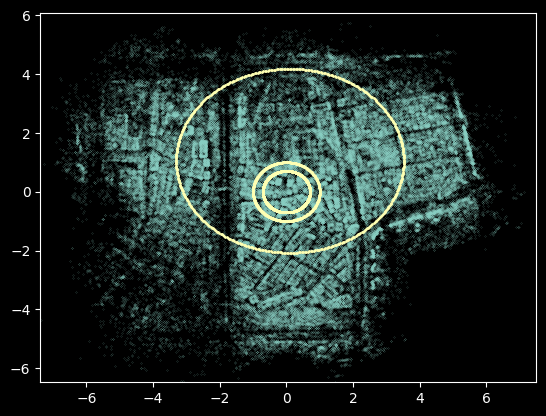

In [8]:
xyz = model.get_xyz
xyz_homo = torch.cat((xyz, torch.zeros(xyz.shape[0], 1, device=xyz.device)), dim=-1)
transformed_xyz = xyz_homo @ torch.tensor(colmap_to_world_transform, device=xyz.device, dtype=xyz.dtype).T
x_min, x_max = pose_recenter[:, 0, -1].min(), pose_recenter[:, 0, -1].max()
y_min, y_max = pose_recenter[:, 1, -1].min(), pose_recenter[:, 1, -1].max()
voxel_size = torch.tensor([(x_max - x_min) / 25, (y_max - y_min) / 25], device=xyz.device)
xy_range = torch.tensor([x_min, y_min, x_max, y_max], device=xyz.device)
vox_mask = voxel_filtering_no_gt(voxel_size, xy_range, transformed_xyz).bool().cpu().numpy()
transformed_xyz = transformed_xyz.cpu().numpy()
plt.figure()
plt.scatter(transformed_xyz[::100, x_dim], transformed_xyz[::100, 1], s=0.01) 
plt.scatter(new_poses_org[:, x_dim, :], new_poses_org[:, y_dim, :], s=1)
plt.xlim(x_min - x_delta, x_max + x_delta)
plt.ylim(y_min - y_delta, y_max + y_delta)
plt.show()

(-0.5, 1599.5, 1063.5, -0.5)

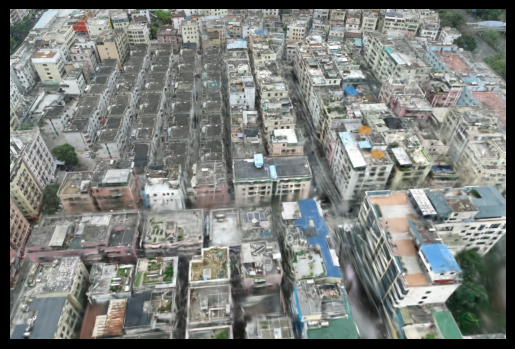

In [33]:
# cam = dataparser_outputs.train_set.cameras[0].to_device('cuda')
cam = traj[120].to_device('cuda')
model.select(vox_mask)
bg_color=torch.tensor(config.model.background_color, dtype=torch.float, device='cuda')
img = renderer(cam, model, bg_color)['render']
img = (img * 255).clamp(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy()
plt.imshow(img)
plt.axis('off')